In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


## Importin libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

## Importing dataset

In [3]:
train_df = pd.read_csv("/kaggle/input/home-data-for-ml-course/train.csv")
test_df = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv")
train_df.drop(columns=['Id'], inplace=True)

## Feature engineering

In [4]:
train_df['Garage_Age'] = train_df['GarageYrBlt'] - train_df['YearBuilt']
train_df["RmsPerSqft"] = train_df["TotRmsAbvGrd"] / train_df["GrLivArea"]
test_df['Garage_Age'] = test_df['GarageYrBlt'] - test_df['YearBuilt']
test_df["RmsPerSqft"] = test_df["TotRmsAbvGrd"] / test_df["GrLivArea"]

In [5]:
train_df = train_df.drop(columns=["YearBuilt", "GarageYrBlt", "TotRmsAbvGrd", "GrLivArea"])
test_df = test_df.drop(columns=["YearBuilt", "GarageYrBlt", "TotRmsAbvGrd", "GrLivArea"])

In [6]:
train_df['TotalArea'] = train_df['1stFlrSF'] + train_df['TotalBsmtSF']
test_df['TotalArea'] = test_df['1stFlrSF'] + test_df['TotalBsmtSF']


In [7]:
target_column = "SalePrice"
X = train_df.drop(columns=[target_column])
y = train_df[target_column]

In [8]:
cat_features = X.select_dtypes(include=["object"]).columns.tolist()
print("Categorical Features:", cat_features)

Categorical Features: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [9]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
X[num_features] = X[num_features].fillna(X[num_features].median())
X[cat_features] = X[cat_features].fillna("None")

test_df[num_features] = test_df[num_features].fillna(test_df[num_features].median())
test_df[cat_features] = test_df[cat_features].fillna("None")

In [10]:
num_features_df = train_df.select_dtypes(include=["int64", "float64"])
num_features_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Garage_Age,RmsPerSqft,TotalArea
0,60,65.0,8450,7,5,2003,196.0,706,0,150,...,0,0,0,0,2,2008,208500,0.0,0.004678,1712
1,20,80.0,9600,6,8,1976,0.0,978,0,284,...,0,0,0,0,5,2007,181500,0.0,0.004754,2524
2,60,68.0,11250,7,5,2002,162.0,486,0,434,...,0,0,0,0,9,2008,223500,0.0,0.003359,1840
3,70,60.0,9550,7,5,1970,0.0,216,0,540,...,0,0,0,0,2,2006,140000,83.0,0.004077,1717
4,60,84.0,14260,8,5,2000,350.0,655,0,490,...,0,0,0,0,12,2008,250000,0.0,0.004095,2290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,2000,0.0,0,0,953,...,0,0,0,0,8,2007,175000,0.0,0.004250,1906
1456,20,85.0,13175,6,6,1988,119.0,790,163,589,...,0,0,0,0,2,2010,210000,0.0,0.003377,3615
1457,70,66.0,9042,7,9,2006,0.0,275,0,877,...,0,0,0,2500,5,2010,266500,0.0,0.003846,2340
1458,20,68.0,9717,5,6,1996,0.0,49,1029,0,...,0,0,0,0,4,2010,142125,0.0,0.004638,2156


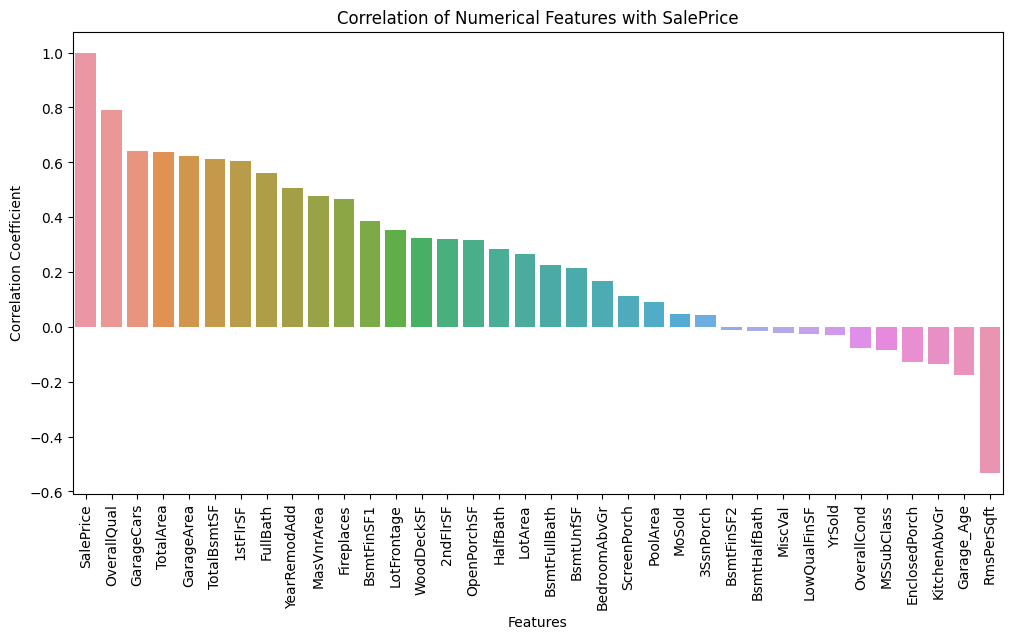

In [11]:
correlation = num_features_df.corr()['SalePrice'].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=correlation.index, y=correlation.values)
plt.xticks(rotation=90)
plt.title('Correlation of Numerical Features with SalePrice')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()

### Dropping features that affect the model the least

In [12]:

train_df.drop(columns = ['LowQualFinSF','3SsnPorch','MoSold','PoolArea','OverallCond','MSSubClass','ScreenPorch'], inplace = True)

## Correlation Matrix

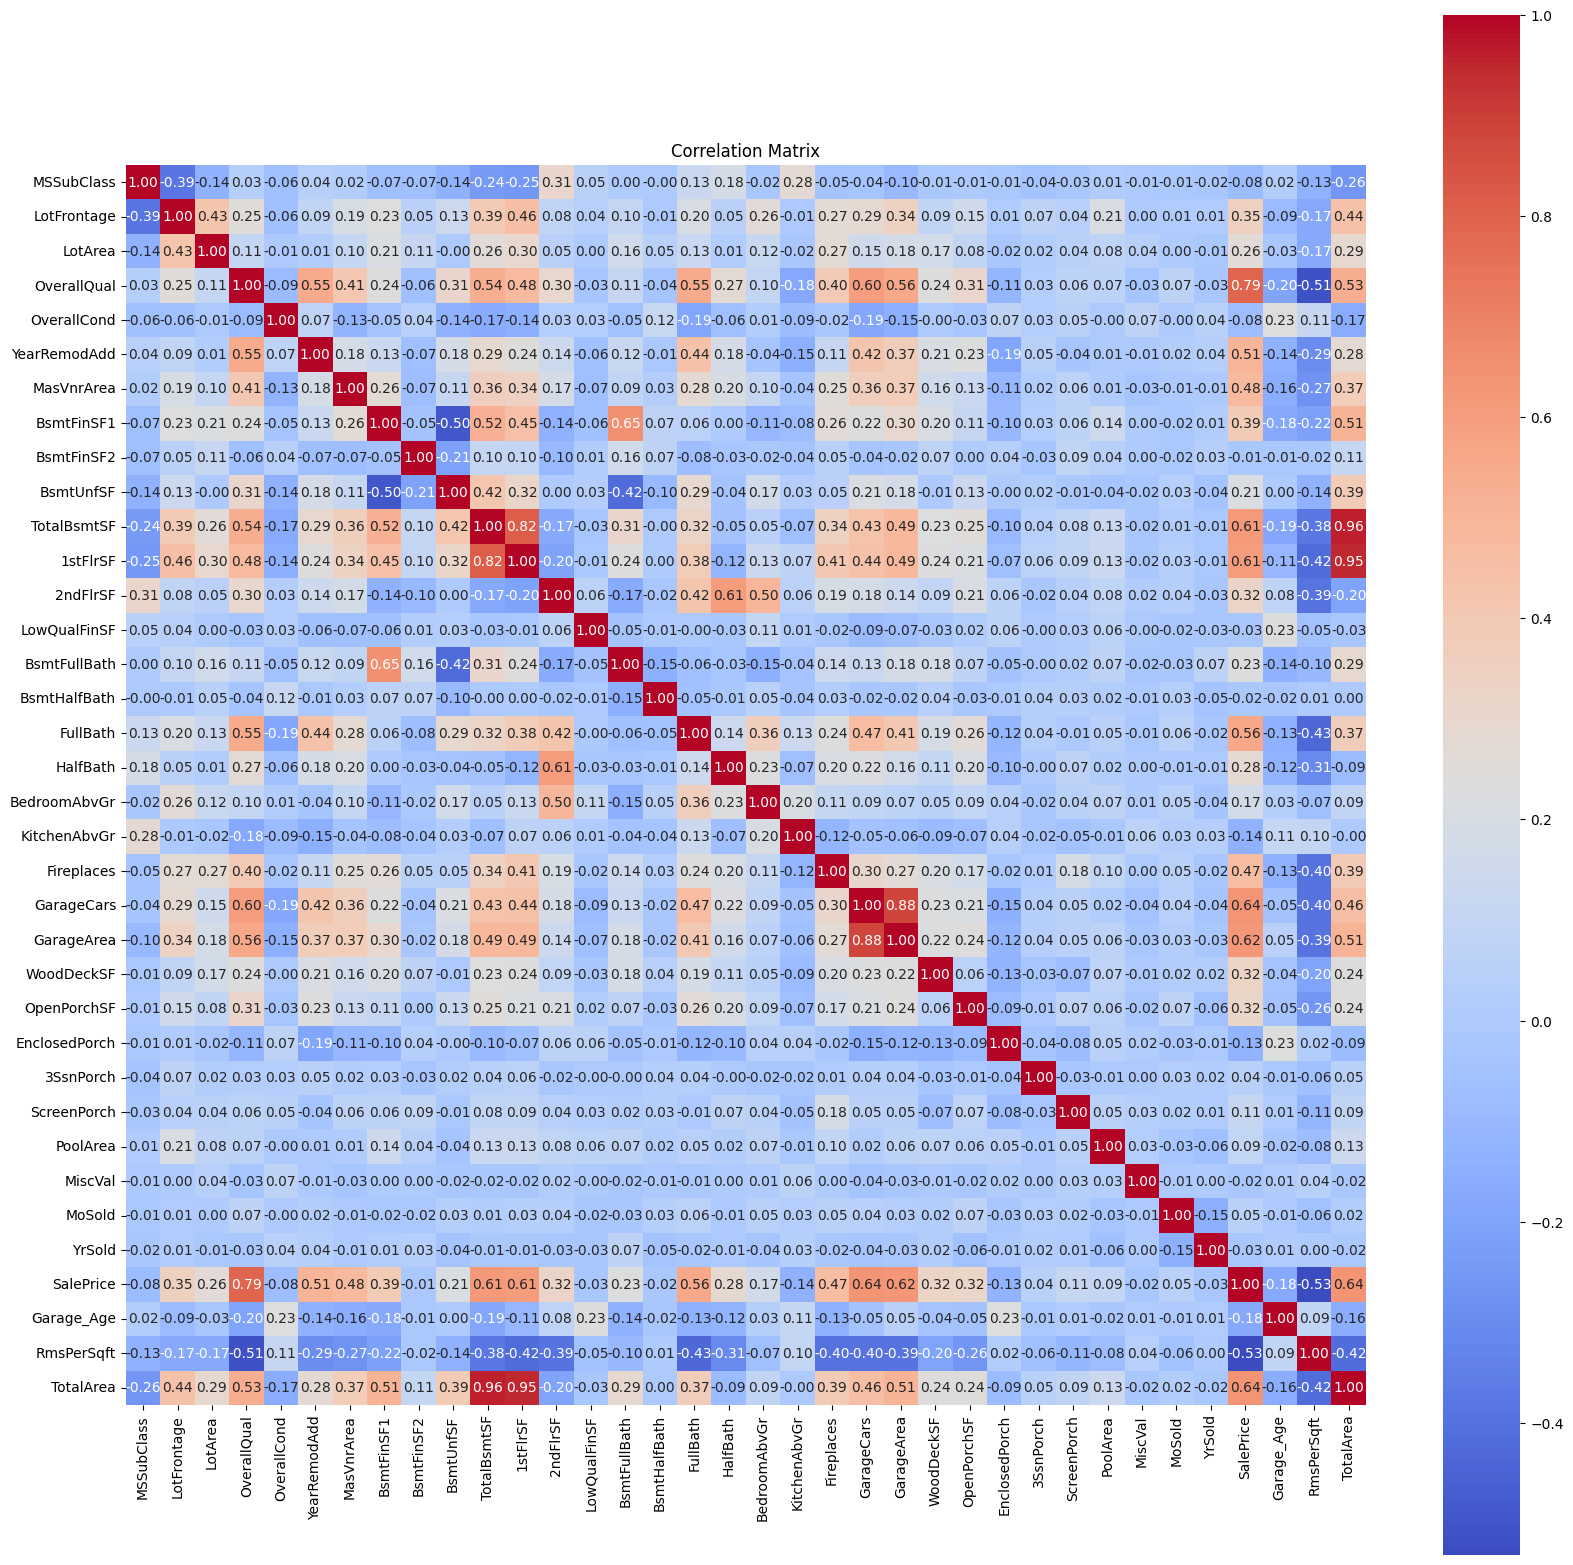

In [13]:
correlation_matrix = num_features_df.corr()
plt.figure(figsize=(20, 20))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Matrix')
plt.show()

## Training model using Kfold cross validation and RandomizedSearch for best parameters

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
catboost_model = CatBoostRegressor(task_type="GPU", gpu_ram_part=0.6, verbose=0)

In [16]:
# param_grid = {
#     "model__iterations": [1000, 2000, 4000],
#     "model__learning_rate": [0.01, 0.05, 0.1],
#     "model__depth": [4, 6, 8],
#     "model__l2_leaf_reg": [1, 3, 5]
# }

# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search with Cross Validation
# grid_search = RandomizedSearchCV(pipeline, param_grid, cv=kf, scoring="neg_root_mean_squared_error", n_jobs=-1, verbose=1, random_state=42)
# grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
# best_model = grid_search.best_estimator_


## Model with best parameters

In [17]:
final_model = CatBoostRegressor(
    learning_rate=0.05,
    l2_leaf_reg=3,
    iterations=4000,
    depth=4,
    cat_features=cat_features,  # Specify categorical features here
    verbose=100
)

final_model.fit(X_train, y_train)

# Evaluate model
y_pred = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Final Model RMSE: {rmse:.4f}")
print(f"Final Model R² Score: {r2:.4f}")

0:	learn: 74849.4396486	total: 65.1ms	remaining: 4m 20s
100:	learn: 24746.4225172	total: 862ms	remaining: 33.3s
200:	learn: 19714.4449879	total: 1.65s	remaining: 31.3s
300:	learn: 17733.0116485	total: 2.46s	remaining: 30.2s
400:	learn: 16242.7343021	total: 3.27s	remaining: 29.4s
500:	learn: 15126.0569866	total: 4.1s	remaining: 28.7s
600:	learn: 14045.6114544	total: 4.97s	remaining: 28.1s
700:	learn: 12983.4764307	total: 5.79s	remaining: 27.3s
800:	learn: 12221.5516466	total: 6.62s	remaining: 26.4s
900:	learn: 11541.0942619	total: 7.46s	remaining: 25.6s
1000:	learn: 10920.3107624	total: 8.3s	remaining: 24.9s
1100:	learn: 10409.4393719	total: 9.13s	remaining: 24s
1200:	learn: 9972.0061376	total: 9.96s	remaining: 23.2s
1300:	learn: 9541.8292840	total: 10.8s	remaining: 22.4s
1400:	learn: 9128.5403542	total: 11.6s	remaining: 21.6s
1500:	learn: 8759.7081244	total: 12.5s	remaining: 20.8s
1600:	learn: 8425.0234169	total: 13.4s	remaining: 20.1s
1700:	learn: 8144.0771695	total: 14.5s	remaining: 

## Making predictions

In [18]:
X_submission = test_df[X.columns]
y_pred_submission = final_model.predict(X_submission)

In [19]:
submission = pd.DataFrame({'Id': test_df['Id'], 'SalePrice': y_pred_submission})
submission.to_csv('submission.csv', index=False)

In [20]:
submission

,Id,SalePrice
0,1461,120219.149021
1,1462,161717.237424
2,1463,191470.790083
3,1464,191683.166685
4,1465,194178.662511
...,...,...
1454,2915,81263.594483
1455,2916,80488.561678
1456,2917,166019.319542
1457,2918,119799.659081
